Logistic, KNN, ANN, Decision Tree

In [22]:
import sys
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import torch
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy
import random

In [23]:
torch.manual_seed(420)
random.seed(420)
numpy.random.seed(420)

In [24]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, h, output_size) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, h),
            nn.ReLU(),  
            nn.Linear(h, h),
            nn.ReLU(),  
            nn.Linear(h, output_size),
            nn.Sigmoid(),
        )

    def forward(self, x): return self.layers.forward(x)

def get_predictions(test_x, model):
    model.eval()
    with torch.no_grad():
        return model(test_x)

def eval_model(model, x_test, y_test):
    model.eval()
    raw_predictions = get_predictions(x_test, model)
    predictions = np.argmax(raw_predictions, axis=1)
    y_test = np.argmax(y_test, axis=1)
    return accuracy_score(predictions, y_test)

def train_model(model, criterion, optimizer, train_loader, epochs, x_test, y_test, learning_rate):
    acc = []
    losses = []
    for epoch in tqdm(range(epochs)):
        for i, (inputs, labels) in enumerate(train_loader):
            model.train()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            losses.append(loss.item())
            # model.zero_grad()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # with torch.no_grad():
            #     for param in model.parameters():
            #         param -= learning_rate * param.grad
        acc.append(eval_model(model, x_test, y_test))
    return acc, losses


def ann(model, x_train, x_test, y_train, y_test, learning_rate, batch_size, epochs):
    
    print(eval_model(model, x_test, y_test))
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
    # optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


    acc, losses = train_model(model, criterion, optimizer, train_loader, epochs, x_test, y_test, learning_rate)
    print(eval_model(model, x_test, y_test))
    return acc, losses

In [25]:
[p for p in SimpleNN(10, 1, 10).parameters()]

[Parameter containing:
 tensor([[ 0.1931, -0.1903,  0.3010, -0.2512, -0.0965, -0.2179,  0.2439,  0.1186,
          -0.1577, -0.2446]], requires_grad=True),
 Parameter containing:
 tensor([-0.1831], requires_grad=True),
 Parameter containing:
 tensor([[-0.1929]], requires_grad=True),
 Parameter containing:
 tensor([-0.5104], requires_grad=True),
 Parameter containing:
 tensor([[ 0.7287],
         [-0.4207],
         [-0.6542],
         [-0.3085],
         [-0.9765],
         [-0.4856],
         [-0.5456],
         [ 0.2152],
         [ 0.8133],
         [ 0.1080]], requires_grad=True),
 Parameter containing:
 tensor([-0.5828,  0.4117, -0.4258, -0.4733, -0.1916, -0.5219,  0.1099,  0.8118,
          0.1364,  0.6040], requires_grad=True)]

In [26]:
data = pd.read_csv("HR_data.csv")
data = data.astype({"Frustrated": str})
data

,Unnamed: 0,HR_Mean,HR_Median,HR_std,HR_Min,HR_Max,HR_AUC,Round,Phase,Individual,Puzzler,Frustrated,Cohort
0,0,77.965186,78.000,3.345290,73.23,83.37,22924.945,round_3,phase3,1,1,1,D1_1
1,1,70.981097,70.570,2.517879,67.12,78.22,21930.400,round_3,phase2,1,1,5,D1_1
2,2,73.371959,73.360,3.259569,67.88,80.22,21647.085,round_3,phase1,1,1,0,D1_1
3,3,78.916822,77.880,4.054595,72.32,84.92,25258.905,round_2,phase3,1,1,1,D1_1
4,4,77.322226,74.550,6.047603,70.52,90.15,23890.565,round_2,phase2,1,1,5,D1_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,163,73.594539,72.380,9.474556,57.43,93.53,21482.985,round_4,phase2,14,0,8,D1_2
164,164,57.839897,54.130,6.796647,52.97,74.14,16825.740,round_4,phase1,14,0,0,D1_2
165,165,64.237295,65.195,3.589241,58.97,72.63,18691.065,round_1,phase3,14,0,1,D1_2
166,166,70.834320,70.440,2.391160,66.65,76.07,20753.005,round_1,phase2,14,0,4,D1_2


In [27]:
x_train = data[data["Individual"] != 1][["HR_Mean", "HR_Median", "HR_std", "HR_Min", "HR_Max", "HR_AUC"]].values
y_train = data[data["Individual"] != 1]["Frustrated"].values
x_test = data[data["Individual"] == 1][["HR_Mean", "HR_Median", "HR_std", "HR_Min", "HR_Max", "HR_AUC"]].values
y_test = data[data["Individual"] == 1]["Frustrated"].values

x_train = torch.tensor(x_train.astype(np.float32))
x_test = torch.tensor(x_test.astype(np.float32))
y_train = torch.tensor(y_train.astype(np.float32))
y_test = torch.tensor(y_test.astype(np.float32))

In [28]:
data["Individual"].value_counts()

1     12
2     12
3     12
4     12
5     12
6     12
7     12
8     12
9     12
10    12
11    12
12    12
13    12
14    12
Name: Individual, dtype: int64

In [29]:
def one_hot_encode(input_tensor, num_classes=None):
    if num_classes is None:
        num_classes = len(torch.unique(input_tensor))
    one_hot_encoded = torch.nn.functional.one_hot(input_tensor.long(), num_classes)
    return one_hot_encoded

y_train = one_hot_encode(y_train, num_classes=11)
y_test = one_hot_encode(y_test, num_classes=11)

0.25


100%|██████████| 1000/1000 [00:30<00:00, 32.36it/s]


0.08333333333333333


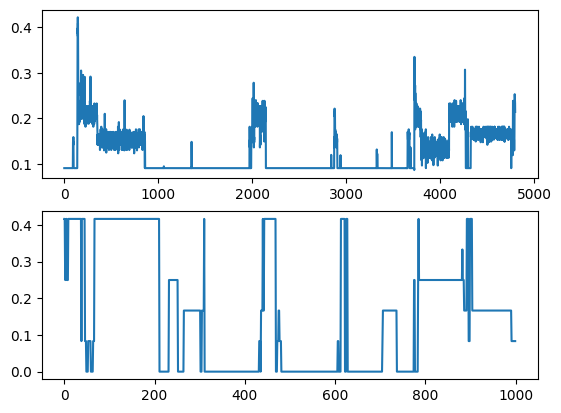

In [31]:
input_size = 6
# binary for status
output_size = 11
learning_rate = 5e-3
epochs = 1000
batch_size = 32
h = 1024

model = SimpleNN(input_size, h, output_size)

acc, losses = ann(model, x_train, x_test, y_train, y_test, learning_rate, batch_size, epochs)
fig, axs = plt.subplots(2,1)
axs[0].plot(losses[200:])
axs[1].plot(acc)
plt.show()